In [17]:
from pykalman import KalmanFilter
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import poly1d

from backtester.dataSource.yahoo_data_source import YahooStockDataSource
from datetime import datetime

Processing data for stock: SPY
Processing data for stock: MSFT
Processing data for stock: ADBE
20% done...
40% done...
60% done...
80% done...


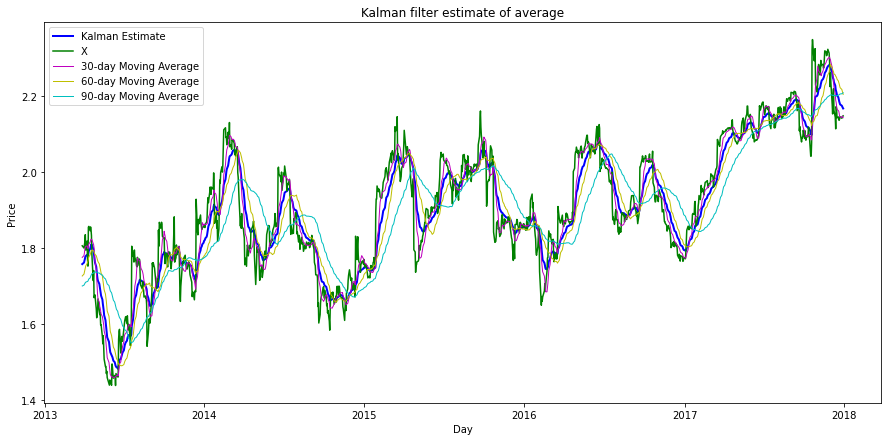

In [18]:


# Load pricing data for a security
startDateStr = '2012/12/31'
endDateStr = '2017/12/31'
cachedFolderName = './yahooData/'
dataSetId = 'testPairsTrading'
instrumentIds = ['SPY','MSFT','ADBE']
ds = YahooStockDataSource(cachedFolderName=cachedFolderName,
                            dataSetId=dataSetId,
                            instrumentIds=instrumentIds,
                            startDateStr=startDateStr,
                            endDateStr=endDateStr,
                            event='history')

# Get adjusted closing price
data = ds.getBookDataByFeature()['adjClose']

# Data for Adobe
S1 = data['ADBE']
# Data for Microsoft
S2 = data['MSFT']

# Take ratio of the adjusted closing prices
x = S1/S2

# Construct a Kalman filter
kf = KalmanFilter(transition_matrices = [1],
                  observation_matrices = [1],
                  initial_state_mean = 0,
                  initial_state_covariance = 1,
                  observation_covariance=1,
                  transition_covariance=.01)

# Use the observed values of the price to get a rolling mean
state_means, _ = kf.filter(x.values)
state_means = pd.Series(state_means.flatten(), index=x.index)

# Compute the rolling mean with various lookback windows
mean30 = x.rolling(window = 10).mean()
mean60 = x.rolling(window = 30).mean()
mean90 = x.rolling(window = 60).mean()

# Plot original data and estimated mean
plt.figure(figsize=(15,7))
plt.plot(state_means[60:], '-b', lw=2, )
plt.plot(x[60:],'-g',lw=1.5)
plt.plot(mean30[60:], 'm', lw=1)
plt.plot(mean60[60:], 'y', lw=1)
plt.plot(mean90[60:], 'c', lw=1)
plt.title('Kalman filter estimate of average')
plt.legend(['Kalman Estimate', 'X', '30-day Moving Average', '60-day Moving Average','90-day Moving Average'])
plt.xlabel('Day')
plt.ylabel('Price');

In [19]:
##Pairs Trading Example
startDateStr = '2007/12/01'
endDateStr = '2017/12/01'
cachedFolderName = 'yahooData/'
dataSetId = 'testPairsTrading2'
instrumentIds = ['ADBE','MSFT']
ds = YahooStockDataSource(cachedFolderName=cachedFolderName,
                            dataSetId=dataSetId,
                            instrumentIds=instrumentIds,
                            startDateStr=startDateStr,
                            endDateStr=endDateStr,
                            event='history')
data = ds.getBookDataByFeature()['adjClose']

Processing data for stock: ADBE
Processing data for stock: MSFT
20% done...
40% done...
60% done...
80% done...


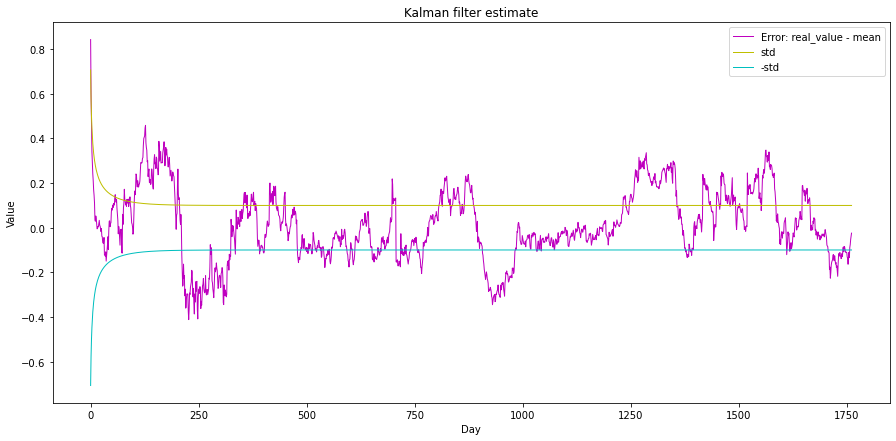

In [20]:
S1, S2 = data['ADBE'].iloc[:1762], data['MSFT'].iloc[:1762]
ratios = S1/S2

kf = KalmanFilter(transition_matrices = [1],
              observation_matrices = [1],
              initial_state_mean = 0,
              initial_state_covariance = 1,
              observation_covariance=1,
              transition_covariance=.0001)

state_means, state_cov = kf.filter(ratios.values)
state_means, state_std = state_means.squeeze(), np.std(state_cov.squeeze())

plt.figure(figsize=(15,7))
plt.plot(ratios.values - state_means, 'm', lw=1)
plt.plot(np.sqrt(state_cov.squeeze()), 'y', lw=1)
plt.plot(-np.sqrt(state_cov.squeeze()), 'c', lw=1)
plt.title('Kalman filter estimate')
plt.legend(['Error: real_value - mean', 'std', '-std'])
plt.xlabel('Day')
plt.ylabel('Value');


In [21]:
def trade(S1, S2):
    # Compute rolling mean and rolling standard deviation
    ratios = S1/S2
    
    kf = KalmanFilter(transition_matrices = [1],
                  observation_matrices = [1],
                  initial_state_mean = 0,
                  initial_state_covariance = 1,
                  observation_covariance=1,
                  transition_covariance=.001)
    
    state_means, state_cov = kf.filter(ratios.values)
    state_means, state_std = state_means.squeeze(), np.std(state_cov.squeeze())
    
    window = 5
    ma = ratios.rolling(window=window,
                               center=False).mean()
    zscore = (ma - state_means)/state_std
    
    # Simulate trading
    # Start with no money and no positions
    money = 0
    countS1 = 0
    countS2 = 0
    for i in range(len(ratios)):
        # Sell short if the z-score is > 1
        if zscore[i] > 1:
            money += S1[i] - S2[i] * ratios[i]
            countS1 -= 1
            countS2 += ratios[i]
        # Buy long if the z-score is < 1
        elif zscore[i] < -1:
            money -= S1[i] - S2[i] * ratios[i]
            countS1 += 1
            countS2 -= ratios[i]
        # Clear positions if the z-score between -.5 and .5
        elif abs(zscore[i]) < 0.5:
            money += countS1*S1[i] + S2[i] * countS2
            countS1 = 0
            countS2 = 0
#         print('Z-score: '+ str(zscore[i]), countS1, countS2, S1[i] , S2[i])
    return money


In [22]:
trade(data['ADBE'].iloc[:1762], data['MSFT'].iloc[:1762])

1591.2236083776893